# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Open, read and assign the traffic sign data
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Step 1.1: Create summary of dataset

In [2]:
import numpy as np

# Calculate number of training examples
n_train = len(y_train)

# Calculate number of testing examples
n_test = len(y_test)

# Calculate shape of an traffic sign image
image_shape = X_train[0].shape

# Calculate number of classes in the dataset
n_classes = np.unique(y_train).size

# Print calculation results
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

### Step 1.2: Create dictionary of traffic sign names

In [3]:
import csv

with open("signnames.csv","r") as csvfile:
    name_reader = csv.DictReader(csvfile)
    sign_names = {}
    for row in name_reader:
        sign_names[int(row["ClassId"])] = row["SignName"]

### Step 1.3: Visualize one image of each traffic sign class

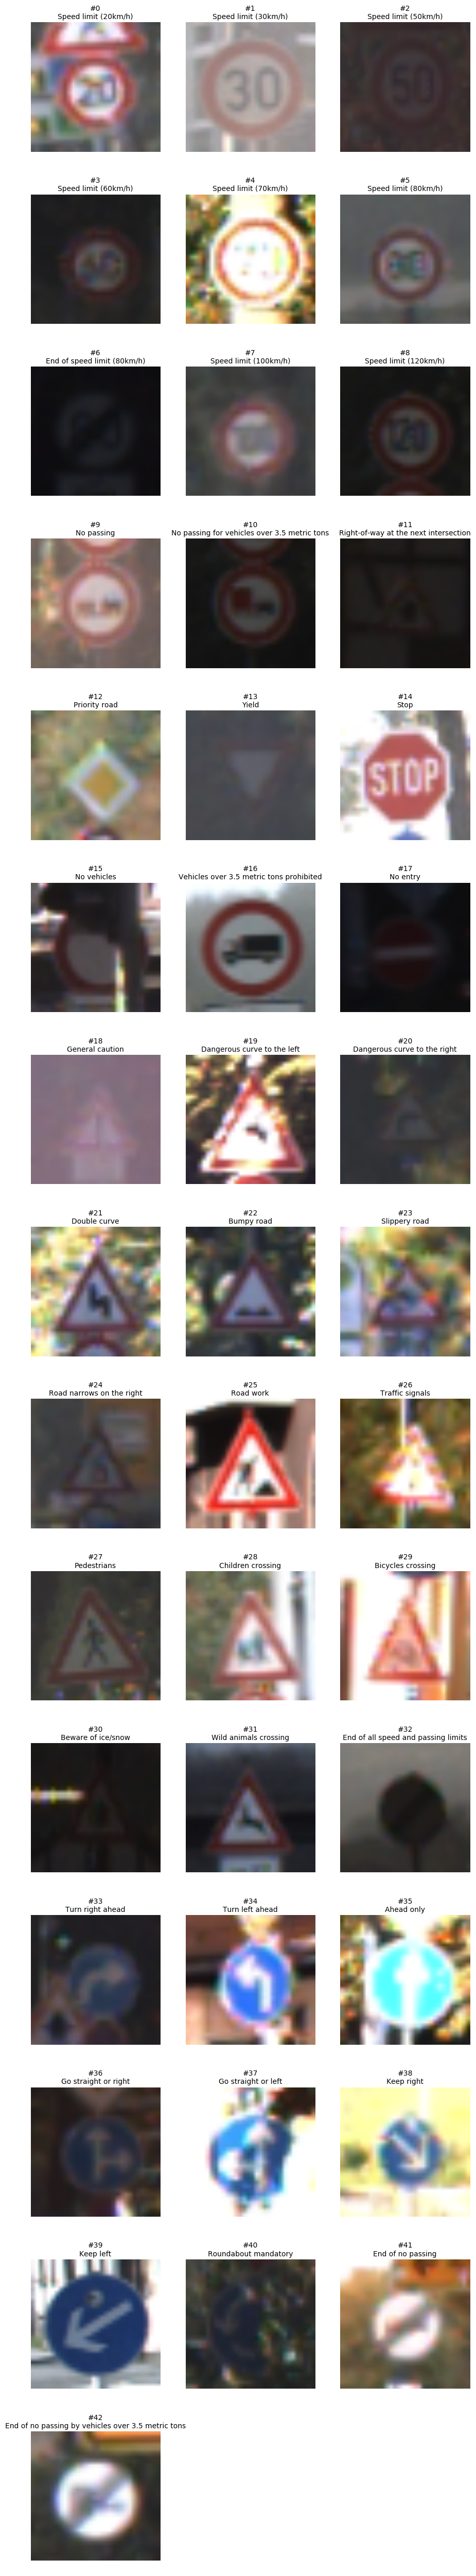

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook
%matplotlib inline

identified_features = []

plt.figure(figsize = (9,50))

for lable, image in zip(y_train, X_train):
    if lable in identified_features:
        continue
    else:
        identified_features.append(lable)
        plt.subplot(15,3,lable+1)
        plt.axis("off")
        plt.title("#{}\n{}".format(lable,sign_names[lable]), fontsize = 10)
        plt.tight_layout(pad = 0, w_pad = 0.1, h_pad=1.0)
        plt.imshow(image)
        if len(identified_features) == n_classes:
            break

### Step 1.4: Visualize current class sizes

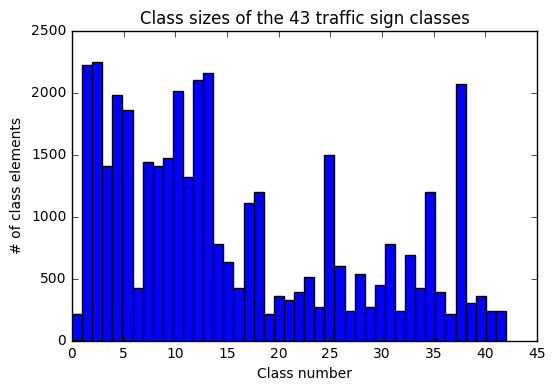

In [5]:
class_sizes = np.bincount(y_train)

plt.hist(y_train,bins=n_classes)
plt.title("Class sizes of the {} traffic sign classes".format(n_classes))
plt.xlabel("Class number")
plt.ylabel("# of class elements")
plt.show()

##### Situation:
The class sizes are very inhomogenous. The CNN sees some types of traffic signs very often and some very seldom. 
##### Complication:
Therefore, the CNN will be biased towards selecting the traffic signs seen very often. 
##### Solution:
To prevent this bias I will create a set with equal class sizes in step 2.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Step 2.1: Preprocess data

#### Step 2.1.1: Create data preprocessing functions for (1) changing images to black and white and (2) standardizing the image values

In [6]:
import math
import random
import cv2
from numpy import newaxis

# Method for changing images to black and white
def black_and_white(conversion):
    bw = []
    for x in range(len(conversion)):
        bw.append(cv2.cvtColor(conversion[x],cv2.COLOR_RGB2GRAY))
    return np.array(bw)[:,:,:,np.newaxis]

# Method for standardizing the image values
def standardize(object):
    return object/255 * 0.8 + 0.1

#### Step 2.1.2: Apply data preprocessing functions on training and test data

In [7]:
# Change X_train to black and white
X_train = black_and_white(X_train)

# Standardize equal training set
X_train = standardize(X_train)
    
# Change X_test to black and white
X_test = black_and_white(X_test)

# Standardize X_test
X_test = standardize(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Preprocessing steps for train and test data:

(1) Changing images to black and white: Transform images to a black and white with OpenCV cvtColor function and adding back lost dimension with np.newaxis -> Reduces image size to 1/3 without loosing much information to reduce model complexity and calculation time. Adding back the lost dimension allows to use the basic LeNet-Network-architecture

(2) Standardizing the image values: Standardizing image pixel values between .1 and .9 -> Prevents error in loss function due to very small or large values

#### Step 2.2: Set up data

#### Step 2.2.1: Create data setup function for creating equal bucket sizes

In [8]:
# Method for creating equal class sizes

def create_equal_training_class_size(X_train,y_train,class_sizes):
    class_size_max = math.ceil(np.amax(class_sizes))

    a = (math.ceil(np.mean(class_size_max))*n_classes,)
    b = X_train.shape[1:4]

    X_train_equal = np.empty(a+b)
    y_train_equal = np.empty(a, dtype=int)

    for x in range(n_classes):
        for y in range(class_size_max):
            randInt = random.randint(0,class_sizes[x]-1)
            X_train_equal[x*class_size_max + y] = X_train[np.sum(class_sizes[:x])+randInt]
            y_train_equal[x*class_size_max+ y] = y_train[np.sum(class_sizes[:x])+randInt]
            #print(x*class_size_max + y)
            #print(np.sum(class_sizes[:x])+randInt)
    return X_train_equal, y_train_equal

#### Step 2.2.2: Create training set with equal class size and visualize class sizes

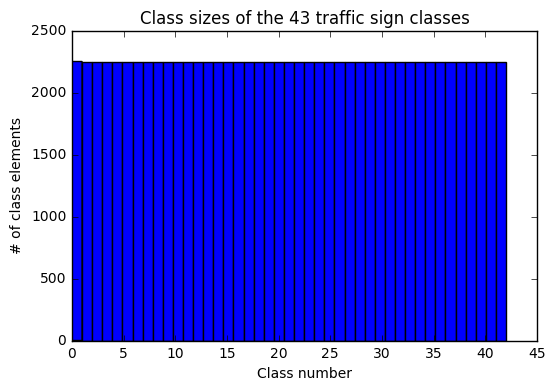

In [9]:
# Create training set with equal class size
X_train, y_train = create_equal_training_class_size(X_train,y_train,class_sizes)

# Visualize class size
plt.hist(y_train,bins=n_classes)
plt.title("Class sizes of the {} traffic sign classes".format(n_classes))
plt.xlabel("Class number")
plt.ylabel("# of class elements")
plt.show()

#### Comment:
The CNN bias towards selecting the traffic signs seen very often is consequently eliminated

#### Step 2.2.3: Split training data into training and validation set

In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle training data before splitting
X_train, y_train = shuffle(X_train,y_train)

# Split current training data into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 15, stratify = y_train)

print("The final training, validation and test set sizes are:")
print()
print("Train set size: {}".format(X_train.shape))
print("Validation set size: {}".format(X_valid.shape))
print("Test set size: {}".format(X_test.shape))

The final training, validation and test set sizes are:

Train set size: (77400, 32, 32, 1)
Validation set size: (19350, 32, 32, 1)
Test set size: (12630, 32, 32, 1)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

(1) Generate additional data / amend existing data: As the number of images per class varied signigicantly (for resulting issues see explanation at the histogram) I created a training set with equal class size. I took the maximum class size and created a new dataset. For each class, a number of images equal to the maximum class size is randomly chosen. I tried this with smaller bucket sizes but the maximum class size proved to be most effective in training.

(2) Set up training, validation and testing data: Split of the training data set imported into training (0.8) and validation part (0.2) via sklearn's train_test_split function. The testing data maintains as imported.

#### Step 2.3: Create model architecture

#### Step 2.3.1: Define # of epoachs, batch size and forward propagation function

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 200

def TSC(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6
    weights1 = tf.Variable(tf.truncated_normal([5,5,1,6],mean = mu, stddev = sigma))
    bias1 = tf.Variable(tf.zeros(6))
    layer1 = tf.add(tf.nn.conv2d(x,weights1,strides=[1,1,1,1],padding="VALID"),bias1)
    
    # Activation (elu-Function). Input = 28x28x1. Output = 28x28x6
    layer1 = tf.nn.elu(layer1)

    # Pooling. Input = 28x28x6. Output = 14x14x6
    layer1Pool = tf.nn.max_pool(layer1,[1,2,2,1],[1,2,2,1],padding = "VALID")
    
    # Dropout Input = 14x14x6. Output = 14x14x6
    layer1Pool =tf.nn.dropout(layer1Pool,keep_prob)

    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16
    weights2 = tf.Variable(tf.truncated_normal([5,5,6,16],mean = mu, stddev = sigma))
    bias2 = tf.Variable(tf.zeros(16))
    layer2 = tf.add(tf.nn.conv2d(layer1Pool,weights2,strides=[1,1,1,1],padding = "VALID"),bias2)
    
    # Activation (elu-Function). Input = 10x10x16. Output = 10x10x16
    layer2 = tf.nn.elu(layer2)

    # Pooling. Input = 10x10x16. Output = 5x5x16
    layer2Pool = tf.nn.max_pool(layer2,[1,2,2,1],[1,2,2,1],padding = "VALID")
    
    # Dropout. Input = 5x5x16. Output = 5x5x16
    layer2Pool =tf.nn.dropout(layer2Pool,keep_prob)

    # Flatten. Input = 5x5x16. Output = 400
    layer2PoolFlat = tf.reshape(layer2Pool,[-1,400])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120
    weights3 = tf.Variable(tf.truncated_normal([400,120],mean = mu, stddev = sigma))
    bias3 = tf.Variable(tf.zeros(120))
    layer3 = tf.add(tf.matmul(layer2PoolFlat,weights3),bias3)
    
    # Activation (elu-Function). Input = 120. Output = 120
    layer3 = tf.nn.elu(layer3)
    
    # Dropout. Input = 120. Output = 120
    layer3 =tf.nn.dropout(layer3,keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84
    weights4 = tf.Variable(tf.truncated_normal([120,84],mean = mu, stddev = sigma))
    bias4 = tf.Variable(tf.zeros(84))
    layer4 = tf.add(tf.matmul(layer3,weights4),bias4)
    
    # Activation (elu-Function). Input = 84. Output = 84
    layer4 = tf.nn.elu(layer4)
    
    # Dropout. Input = 84. Output = 84
    layer4 =tf.nn.dropout(layer4,keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43
    weights5 = tf.Variable(tf.truncated_normal([84,43],mean = mu, stddev = sigma))
    bias5 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(layer4,weights5),bias5)
    
    return logits

#### Step 2.3.2: Initialize variable placeholder and classifier one hot encoding

In [12]:
x = tf.placeholder(tf.float32,(None,32,32,1))
y = tf.placeholder(tf.int32,(None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y,n_classes)

#### Step 2.3.3: Create training pipeline including forward propagation, backward propagation and optimization

In [13]:
training_rate = 0.0015
dropout_keep_prob_train = 0.7
dropout_keep_prob_eval = 1

logits = TSC(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = training_rate)
training_operation = optimizer.minimize(loss_operation)

#### Step 2.3.4: Initialize model evaluation function

In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:dropout_keep_prob_eval})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The structure of my convolutional neuronal network is as follows:

1) Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6

2) Activation (elu-Function). Input = 28x28x1. Output = 28x28x6

3) Pooling. Input = 28x28x6. Output = 14x14x6

4) Dropout Input = 14x14x6. Output = 14x14x6

5) Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16

6) Activation (elu-Function). Input = 10x10x16. Output = 10x10x16

7) Pooling. Input = 10x10x16. Output = 5x5x16

8) Dropout. Input = 5x5x16. Output = 5x5x16

9) Flatten. Input = 5x5x16. Output = 400

10) Layer 3: Fully Connected. Input = 400. Output = 120 

11) Activation (elu-Function). Input = 120. Output = 120 

12) Dropout. Input = 120. Output = 120

13) Layer 4: Fully Connected. Input = 120. Output = 84 

14) Activation (elu-Function). Input = 84. Output = 84 

15) Dropout. Input = 84. Output = 84  

16) Layer 5: Fully Connected. Input = 84. Output = 43

#### Step 2.4: Train and evaluate the model

#### 2.4.1: Train model with training and validation data

In [15]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for epoch in range(EPOCHS):
        X_train, y_train = shuffle(X_train,y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:dropout_keep_prob_train})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(epoch+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, "trafficSignClassifier.ckpt")
    print("Model saved as trafficSignClassifier.ckpt")
            

Training...

EPOCH 1 ...
Validation Accuracy = 0.911

EPOCH 2 ...
Validation Accuracy = 0.957

EPOCH 3 ...
Validation Accuracy = 0.968

EPOCH 4 ...
Validation Accuracy = 0.980

EPOCH 5 ...
Validation Accuracy = 0.984

EPOCH 6 ...
Validation Accuracy = 0.986

EPOCH 7 ...
Validation Accuracy = 0.988

EPOCH 8 ...
Validation Accuracy = 0.989

EPOCH 9 ...
Validation Accuracy = 0.990

EPOCH 10 ...
Validation Accuracy = 0.992

Model saved as trafficSignClassifier.ckpt


#### Step 2.4.2: Perform final model evaluation based on test set

In [16]:
# Launch the model on the test data
with tf.Session() as sess:
    saver.restore(sess, "trafficSignClassifier.ckpt")

    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob : dropout_keep_prob_eval})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9382422566413879


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**

Cost-function: Cross-entropy cost function

Type of optimizer: Adam optimizer

Batch size: 200

Epochs: 10

Hyperparameters:
Mean:0; 
Sigma:0.1

Dropout "keep-probability": 0.7


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with the LeNet-architecture as it worked very well on the image classification problem discussed in class. Based on what I learned in class I took an iterative trial and error process to adjust the LeNet-architecture to the traffic sign classification problem:

(1) Implementation of dropout function after Max-Pooling on layer 1 to reduce overfitting

(2) Implementation of dropout function after Max-Pooling on layer 4 

(3) Change of ReLu-functions to eLu-functions, which resulted in significant classification improvement

(4) Implementation of dropout function after Max-Pooling on layer 1

Regarding the model parameters I took a trial and error approach applying sensitivity analysis on parameters such as batch size, epochs and dropout rates.

Beyond, the homogenization of class sizes as elaborated in my answer to question 2 resulted in significant classification improvements.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Step 3.1: Preprocess own images

#### Step 3.1.1: Load own data (images)

In [17]:
import os
import matplotlib.image as mpimg
from scipy import misc

files = os.listdir("self-generated-test-images/")
X_own = []
iterator = 1
for fn in files:
    X_own.append(cv2.resize(mpimg.imread("self-generated-test-images/{}".format(fn),1),(32,32), interpolation = cv2.INTER_AREA))
    iterator += 1

#### Step 3.1.2: Plot own data (images)

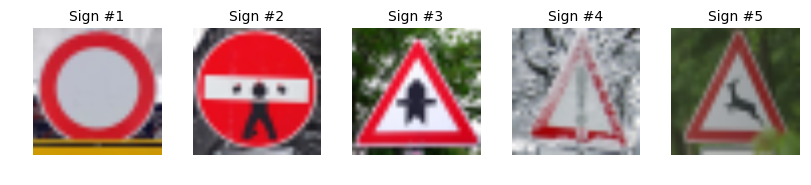

In [18]:
plt.figure(figsize = (8,15))

position = 1
for image in X_own:
    plt.subplot(1,5,position)
    plt.axis("off")
    plt.title("Sign #{}".format(position), fontsize = 10)
    plt.tight_layout(pad = 0, w_pad = 0.1, h_pad=1.0)
    plt.imshow(image)
    position += 1

#### Step 3.1.3: Apply data preprocessing functions on own data

In [19]:
# Change X_own to black and white
X_own_adjust = black_and_white(X_own)

# Standardize X_own set
X_own_adjust = standardize(X_own_adjust)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I took five traffic sign pictures from the internet. In this notebook I imported and resized them to suit the model.

Remarks on the images:

Sign #1 No vehicles sign: No classification difficulty expected

Sign #2 No entry: Potential classification difficulty as there is graffity on the sign

Sign #3 Right of way at the next intersection sign: No classification difficulty expected

Sign #4 General caution sign: Potential classification difficulty as the sign is partly covered by snow

Sign #5 Wild animal crossing sign: Potential small classification difficulty as a very small part of the image is covered by a tree

In the end I preprocessed the images by making them black and white and applying standardization as applied on the initial data. 

#### Step 3.2: Run predictions on own data

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "trafficSignClassifier.ckpt")

    X_own_classes = sess.run(logits, feed_dict={x: X_own_adjust, keep_prob : 1.0})

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

As one can see in the printed images in the next step (3.3) there is a 80% accuracy on the captured pictures.

#### Step 3.3: Get and display top 5 predictions per image

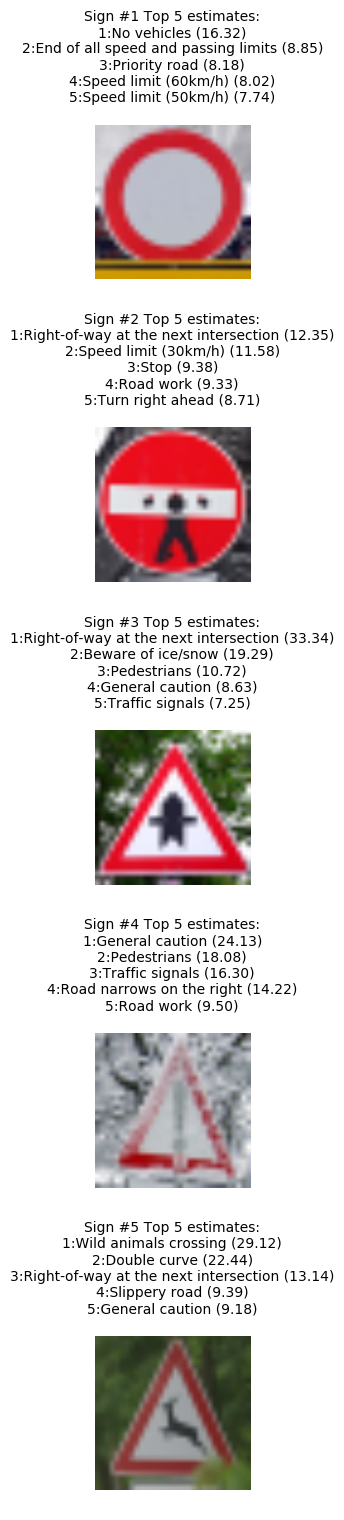

In [21]:
# Read out prediction certainties for top 5 predictions per image
with tf.Session() as sess:
    classifier_guesses = sess.run(tf.nn.top_k(X_own_classes, k=5, sorted=True))

# Plot images with top 5 predictions
plt.figure(figsize = (8,15))
position = 1
for image in X_own:
    plt.subplot(5,1,position)
    plt.axis("off")
    plt.title("Sign #{} Top 5 estimates:\n1:{} ({:.2f})\n2:{} ({:.2f})\n3:{} ({:.2f})\n4:{} ({:.2f})\n5:{} ({:.2f})\n".format(position,sign_names[classifier_guesses[1][position-1][0]],classifier_guesses[0][position-1][0],sign_names[classifier_guesses[1][position-1][1]],classifier_guesses[0][position-1][1],sign_names[classifier_guesses[1][position-1][2]],classifier_guesses[0][position-1][2],sign_names[classifier_guesses[1][position-1][3]],classifier_guesses[0][position-1][3],sign_names[classifier_guesses[1][position-1][4]],classifier_guesses[0][position-1][4]), fontsize = 10, ha = "center")
    plt.tight_layout(pad = 0, w_pad = 0.1, h_pad=1.0)
    plt.imshow(image)
    position += 1

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In the above visualization one can see the top 5 predictions and their values in brackets. The model was able to achieve 80% accuracy. All correctly identified traffic signs are clearly predicted. Only the no entry sign was not labled correctly. No entry is not even amongst the top 5 predictions. As the sign has some graffity on it, it is not recognized by the classifier.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.